<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_ImageCaptioning_Lab_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speaker: Ba Ngoc - Founder @ProtonX @VietAI Hanoi

## 1. Bổ sung các thư viện cần thiết

In [1]:
#@title Cài đặt các thư viện cần thiết
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from os import listdir
from os.path import isfile, join

!pip install -q tqdm
from tqdm import tqdm

#### Lựa chọn bộ dữ liệu

In [2]:
images_file_name = 'small_data'  #@param ["tiny_data", "small_data", "large_data"]

mapping = {
'small_data': 'https://storage.googleapis.com/protonx-cloud-storage/images1000.zip',
'large_data' : 'https://storage.googleapis.com/protonx-cloud-storage/images5000.zip',
'tiny_data': 'https://storage.googleapis.com/protonx-cloud-storage/images500.zip'
}

images_link = mapping[images_file_name]
captions_link = 'https://storage.googleapis.com/protonx-cloud-storage/annotations_trainval2014.zip'

folder_mapping = {
'small_data': '/workshop_data_small/',
'large_data' : '/workshop_data/',
'tiny_data': '/workshop_data_tiny/'
}

image_folder = folder_mapping[images_file_name]

In [3]:
#@title Tải về các miêu tả
# Tải các câu miêu tả
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = captions_link,
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
  annotation_file = '/content/annotations/captions_train2014.json'


252878848/252872794 [==============================] - 2s 0us/step


In [4]:
#@title Tải về ảnh

if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('images.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = images_link,
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

976814080/976807594 [==============================] - 7s 0us/step


#### Đọc dữ liệu

In [5]:
#@title Đọc file json chứa các miêu tả

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [6]:
#@title Nối link ảnh và caption tương ứng

image_files = [f for f in listdir(PATH) if isfile(join(PATH, f))]
aSet = set(image_files)


image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_name = 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  if image_name in aSet:
    image_path = PATH + image_name
    image_path_to_caption[image_path].append(caption)

In [7]:
# Kiểm tra số ảnh
len(image_path_to_caption)

1000

Một link ảnh có thể có nhiều miêu tả

In [8]:
#@title Tráo ảnh
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Chọn số lượng ảnh mong muốn:
train_image_paths = image_paths[:]
print(len(train_image_paths))

1000


In [9]:
#@title Nối từng ảnh với từng miêu tả
# Duỗi thành 2 mảng chứa caption và ảnh tương ứng. Một bức ảnh có thể có nhiều caption miêu tả \n
# Trường hợp này ta sẽ sắp xếp sử dụng 1 ảnh - 1 miêu tả
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list)) 

<start> A little boy in a field swinging his baseball bat. <end>


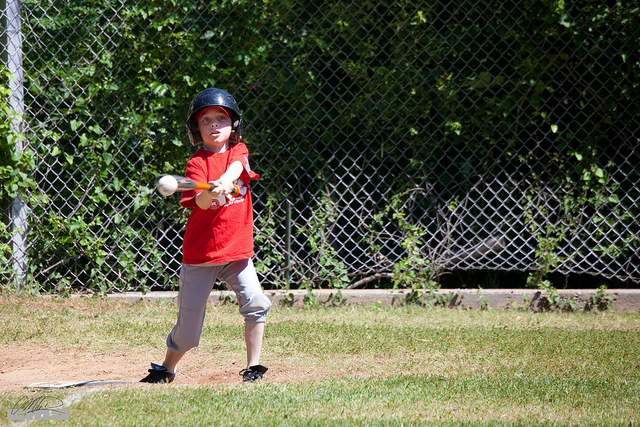

In [10]:
#@title Hiển thị ảnh
idx = "14"  #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
print(train_captions[int(idx)])
Image.open(img_name_vector[int(idx)])

#### Xây dựng tensorflow dataset

In [11]:
#@title Tải về Inception V3
# Load Inceptionv3 chuẩn bị cho việc đưa các ảnh qua để sử dụng feature map hữu ích 

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output # 8x8x2048

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [12]:
#@title Xây dựng TF dataset
# Hàm đọc ảnh. 
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # Đổi chiều ảnh để phù hợp với yêu cầu của inceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img) # Đưa ảnh về feature maps (16, 8, 8, 2048)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3])) # Nén chiều (16, 64, 2048)
  
  for bf, p in zip(batch_features, path): # Lưu dưới dạng .npy
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


#### Tiền xử lý và tokenize miêu tả - TODO

In [13]:
#@title Tìm chiều dài lớn nhất của bất kỳ một caption nào trong dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
#@title Chuyển văn bản thành từ điển
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>", # unk ko ton tai trong tu dien
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

#### TODO 1: Xây dựng từ điển
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index


{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'at': 15,
 'an': 16,
 'people': 17,
 'two': 18,
 'standing': 19,
 'are': 20,
 'next': 21,
 'street': 22,
 'table': 23,
 'white': 24,
 'woman': 25,
 'that': 26,
 'holding': 27,
 'it': 28,
 'large': 29,
 'group': 30,
 'some': 31,
 'tennis': 32,
 'front': 33,
 'person': 34,
 'small': 35,
 'up': 36,
 'his': 37,
 'near': 38,
 'train': 39,
 'sign': 40,
 'down': 41,
 'water': 42,
 'riding': 43,
 'top': 44,
 'field': 45,
 'by': 46,
 'young': 47,
 'room': 48,
 'red': 49,
 'black': 50,
 'bathroom': 51,
 'beach': 52,
 'cat': 53,
 'walking': 54,
 'while': 55,
 'playing': 56,
 'parked': 57,
 'has': 58,
 'bus': 59,
 'green': 60,
 'food': 61,
 'plate': 62,
 'baseball': 63,
 'bed': 64,
 'blue': 65,
 'ball': 66,
 'for': 67,
 'dog': 68,
 'flying': 69,
 'three': 70,
 'pizza': 71,
 'laptop': 72,
 'boy': 73,
 'several': 74,
 'there': 75,
 'pla

In [17]:
#@title Thêm padding cho từ điển
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
#### TODO 2: Chuyển miêu tả thành sequence 
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
train_seqs[:2]

[[3, 2, 72, 11, 5, 9, 2, 367, 16, 1879, 1373, 14, 21, 13, 28, 4],
 [3, 2, 128, 9, 2, 72, 10, 2, 367, 10, 1374, 14, 5, 28, 4]]

In [26]:
#### TODO 3: Padding để đảm bảo câu có cùng chiều dài
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') # post them padding vao dang sau

In [27]:
cap_vector[:2]

array([[   3,    2,   72,   11,    5,    9,    2,  367,   16, 1879, 1373,
          14,   21,   13,   28,    4,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,  128,    9,    2,   72,   10,    2,  367,   10, 1374,
          14,    5,   28,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [23]:
#@title Tính chiều dài lớn nhất của câu
max_length = calc_max_length(train_seqs)

In [24]:
max_length

42

#### Chia tập test và tập train

In [28]:
#@title Chia tập Test và tập train

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [29]:
len(img_name_train), len(img_name_val)

(4003, 1002)

#### Cài đặt siêu tham số

In [30]:

# Định nghĩa các siêu tham số (hyper parameter) của mô hình

#### TODO 4: Số lượng data được sử dụng trong một lần đưa vào mô hình
BATCH_SIZE = 64

BUFFER_SIZE = 1000 

# Chiều khi đưa qua embedding
embedding_dim = 256 

#### TODO 5: Chiều của hidden state 
units = 512

# Số lượng từ trong từ điển
vocab_size = top_k + 1

# Số bước training 
num_steps = len(img_name_train) // BATCH_SIZE 

# Chiều của features shape
features_shape = 2048 

# Chiều của attention
attention_features_shape = 64


In [31]:
#@title Tải ảnh vào Dataset
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Load ảnh từ file
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#### Mô hình

Cơ chế Attention tìm những kết nối giữa từ và vùng ảnh quan hệ mật thiết với nhau

In [32]:
#@title Cơ chế Attention
# Sử dụng hidden phía trước để thực hiện kết nối với những khu vực ảnh quan trọng (features từ đầu ra của CNN)
# Vector hidden này bao gồm thông tin quan trọng từ đầu câu đến vị trí phía trước

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    # 1. Chiều của features: (batch_size, 64, embedding_dim)
    # 2. Chiều của hidden: (batch_size, units)
    # 3. Mở rộng chiều hidden_with_time_axis: (batch_size, 1, units)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)


    # 1. Biến đổi tuyến tính features về chiều (batch_size, 64, units)
    # 2. Biến đổi hidden_with_time_axis về chiều (batch_size, 1, units)
    # 3. Broadcasting hidden_with_time_axis vào features. 
    # 4. Đầu ra attention_hidden_layer: (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))


    # 1. Đưa qua biến đổi tuyến tính từ (batch_size, 64, units) về (batch_size, 64, 1)
    # 2. score này thể hiện 64 mối quan hệ của vector hidden với 64 khu vực ảnh
    score = self.V(attention_hidden_layer)

    
    # 1. Thực hiện softmax để tìm ra xác suất khu vực quan trọng. 
    # 2. Tổng các giá trị này sẽ bằng 1 
    # 3. Chiều của attention_weights: (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)


    # 1. Bổ sung mối quan hệ này vào các khu vực hiện tại và tổng hợp lại thành một vector
    # 2. Chiều của context_vector: (batch_size, embedding_dim)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    

    return context_vector, attention_weights

In [33]:
#@title Kiểm tra chiều Attention

def checkShape(var):
  print('Shape: {}'.format(var.shape))

batch_size = 16
att = BahdanauAttention(units)
features = tf.ones((batch_size, 64, embedding_dim))
hidden = tf.ones((batch_size, units))
context_vector, attention_weights = att(features, hidden)
print('Chiều của từ được bổ sung liên kết - context vector {}'.format(context_vector.shape))
print('Chiều ma trận quan hệ attention_weights {}'.format(attention_weights.shape))

Chiều của từ được bổ sung liên kết - context vector (16, 256)
Chiều ma trận quan hệ attention_weights (16, 64, 1)


In [34]:
#@title Kiến trúc Encoder - Đọc hình ảnh
class CNN_Encoder(tf.keras.Model):

    # Đưa các feature map đã trích xuất từ inceptionv3 qua một mạng nơ ron

    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # Đầu vào: (batch_size, 64, features_shape)
        x = self.fc(x)
        x = tf.nn.relu(x) # Đầu ra của mạng nơ ron: (batch_size, 64, embedding_dim)
        return x

In [35]:
#@title Kiến trúc Decoder - Dự đoán từ
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # 1. Thực hiện attention hidden state và các vùng ảnh và tìm ra 
    # các trọng số quan hệ attention_weights và vector được bổ sung quan hệ
    context_vector, attention_weights = self.attention(features, hidden)

    # 1. Đưa một từ qua Embedding để trích xuất vector thông tin 
    # 2. Chiều của vector embedding (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 1. Nối x và context_vector để tiến hành dự đoán
    # 2. x chứa thông tin của từ hiện tại và mối quan hệ của hidden state phía trước và các khu vực ảnh
    # 3. Chiều mới của x. (batch_size, 1, embedding_dim) + (batch_size, 1, embedding_dim) = (batch_size, 1, 2 * embedding_dim)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 1. Đưa x qua mạng GRU để sinh ra hidden hiện tại
    # 2. Chiều của output: (batch_size, 1, units). (Toàn bộ các state ở các timestep)
    # 3. Chiều của state: (batch_size, 1, units). 
    output, state = self.gru(x)

    # 1. Đưa x qua mạng nơ ron 
    # 2. Chiều của x: (batch_size, 1, units)
    x = self.fc1(output)

    # 1. Nén chiều của x từ (batch_size, 1, units) thành (batch_size * 1, units)
    x = tf.reshape(x, (-1, x.shape[2]))

    # 1. Tiếp tục đưa qua mạng nơ ron. 
    # 2. Chiều của x: (batch_size * 1, units) -> (batch_size * 1, vocab_size)
    x = self.fc2(x)


    # Chiều của đầu ra:
    # x: (batch_size * 1, vocab_size)
    # hidden state: (batch_size, units)
    # attention_weights: (batch_size, 64, 1)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
# Khởi tạo nhưng chưa chạy - Encoder/Decoder

#### TODO 6: Khởi tạo Encoder
encoder = CNN_Encoder(embedding_dim)

#### TODO 7: Khởi tạo Decoder
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [37]:
#@title Kiểm tra chiều encoder
image_features = tf.ones((16, 64, features_shape))
encoder_output = encoder(image_features)

# Expected Shape: (16, 64, embedding_dim) = (16, 64, 256)
# Real Shape: 
features = encoder(image_features)
print('Chiều của các vùng ảnh quan trọng được trích xuất từ Inception V3: {}'.format(features.shape))

Chiều của các vùng ảnh quan trọng được trích xuất từ Inception V3: (16, 64, 256)


In [38]:
#@title Kiểm tra chiều decoder
hidden = tf.ones((16, units))
features = tf.ones((16, 64, embedding_dim))
w = tf.ones((16, 1))
x, state, attention_weights = decoder(w, features, hidden)

print('Vector sử dụng để dự đoán từ tiếp theo: {}'.format(x.shape))
print('Hidden state hiện tại: {}'.format(state.shape))
print('Ma trận thể hiện mối quan hệ giữa hidden state phía trước với các khu vực ảnh attention_weights: {}'.format(attention_weights.shape))

Vector sử dụng để dự đoán từ tiếp theo: (16, 5001)
Hidden state hiện tại: (16, 512)
Ma trận thể hiện mối quan hệ giữa hidden state phía trước với các khu vực ảnh attention_weights: (16, 64, 1)


#### Cài đặt thuật toán

In [39]:
#@title Cài đặt thuật toán training: Adam. Hàm mất mát: CrossEntropy
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#### Lưu trữ checkpoint

In [41]:
#@title Tải về và load checkpoint đã được train trước

checkpoint_folder = '/check_point/'
checkpoint_path = 'https://storage.googleapis.com/protonx-cloud-storage/check_point.zip'

if not os.path.exists(os.path.abspath('.') + checkpoint_folder):
  checkpoint_zip = tf.keras.utils.get_file('check_point.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = checkpoint_path,
                                          extract = True)
  os.remove(checkpoint_zip)

checkpoint_path = "/content/check_point/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # Sử dụng tham số đã được train từ trước
  ckpt.restore(ckpt_manager.latest_checkpoint)

#### Định nghĩa bước training

In [45]:
#@title Bước Training - TODO

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # 1. Khởi tạo hidden state. Chiều: (batch_size, 512)
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # 2. Tạo từ xuất phát dự đoán với token mở đầu là: <start>. Chiều: (batch_size, 1)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  # 3. Sử dụng Gradient Tape để tính lan truyền ngược sau này
  
  with tf.GradientTape() as tape: # cach tinh dao ham GradientTape()

      # 4. Lấy features hữu tích từ encoder ảnh: 
      

      #### TODO 8: Chạy Encoder
      features = encoder(img_tensor)       # 5. Chiều: (batch_size, 64, embedding_dim)

      # 6. Lặp từ vị trí tiếp theo đến hết câu trong nhãn 
      
      for i in range(1, target.shape[1]):
          
          # 7. Đưa features và hidden phía trước cùng với từ hiện tại đi qua decoder
          # 8. Kết quả thu được dự đoán từ tiếp theo và hidden hiện tại
          # lich su den tu phia trc, tu hien tai va tu tiep theo
          predictions, hidden, _ = decoder(dec_input, features, hidden) #### TODO 9: Chạy Decoder

          # 9. Tính sai lệch giữa kết quả dự đoán và nhãn thật

          loss += loss_function(target[:, i], predictions)

          # 10. Vì là quá trình training cho nên không sử dụng từ dự đoán ra để đưa vào 
          # mô hình mà tiếp tục sử dụng từ tiếp theo trong nhãn. Quá trình này còn được gọi là teacher forcing

          dec_input = tf.expand_dims(target[:, i], 1) # Chiều (batch_size, 1)

  # 11. Tính loss trung bình
  total_loss = (loss / int(target.shape[1]))

  # 12. Lấy ra các tham số cần cập nhật của mô hình
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # 13. Lấy ra gradient của loss theo những tham số này
  gradients = tape.gradient(loss, trainable_variables)

  # 14. Cập nhật giá trị tham số thông qua gradient.
  optimizer.apply_gradients(zip(gradients, trainable_variables)) #### TODO 10: Cập nhật tham số

  return loss, total_loss

In [46]:
#@title Tiến hành Training
loss_plot = []

EPOCHS = 10

# 1. Lặp qua các epoch: Epoch có thể coi là số lần lặp qua toàn bộ tập dữ liệu và cập nhật tham số

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    # 2. Trong mỗi epoch chia thành nhiều phần nhỏ, và tiến hành train trên các phần nhỏ này

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)  #### TODO 11: Cài đặt bước training
        
        # 3. Cộng dồn mất mát trên các phần nhỏ này
        total_loss += t_loss

        # 4. In mất mát
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 6 Batch 0 Loss 2.4503
Epoch 6 Loss 1.574509
Time taken for 1 epoch 86.9875020980835 sec

Epoch 7 Batch 0 Loss 1.3622
Epoch 7 Loss 1.325737
Time taken for 1 epoch 20.244934797286987 sec

Epoch 8 Batch 0 Loss 1.3419
Epoch 8 Loss 1.211972
Time taken for 1 epoch 19.75533652305603 sec

Epoch 9 Batch 0 Loss 1.0840
Epoch 9 Loss 1.093942
Time taken for 1 epoch 19.870341062545776 sec

Epoch 10 Batch 0 Loss 1.1647
Epoch 10 Loss 0.972578
Time taken for 1 epoch 20.062509059906006 sec



#### Tiến hành dự đoán

In [47]:
#@title Tiến hành dự đoán - TODO
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # 1. Khởi tạo hidden state
    hidden = decoder.reset_state(batch_size=1)

    # 2. Đưa ảnh đầu vào qua InceptionV3
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    # 3. Encode ảnh 
    features = encoder(img_tensor_val)

    # 4. Định nghĩa từ mồi: <start>
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    # 5. Lặp qua chiều dài nhất có thể của câu. 
    # 5.1. Trong quá trình dự đoán nếu gặp token <end>: phá vỡ vòng for
    # 5.2. Nếu không gặp token <end> thì câu dự đoán có chiều dài lớn nhất bằng max_length

    for i in range(max_length):

        # 6. Đưa từ, features của ảnh và hidden state phía trước đi qua decoder 
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # 7. Dự đoán token của từ tiếp theo
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        # 8. Nếu gặp token <end> thì phá vỡ vòng lặp
        #### TODO 12: Xử lý khi gặp token <end>
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        # 9. Gán lại từ đầu vào để sử dụng cho lần tiếp theo
        #### TODO 13: Sử dụng từ cho lần dự đoán tiếp
        dec_input = tf.expand_dims([predicted_id], 0)


    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [48]:
#@title Hàm hiển thị sự liên kết
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a little boy in a red shirt swinging at a baseball <end>
Prediction Caption: a person jumping at a horse together with shoes <end>


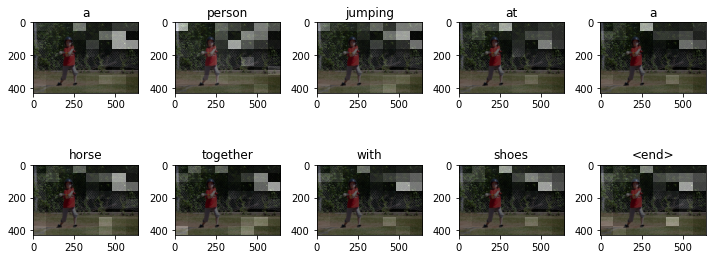

In [49]:
#@title Test trên bộ validation

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
Image.open(img_name_vector[rid])
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

#### Sử dụng một ảnh bên ngoài

1548288/1542936 [==============================] - 0s 0us/step
Prediction Caption: there are wii a frisbee in his zoo holding on a fire <end>


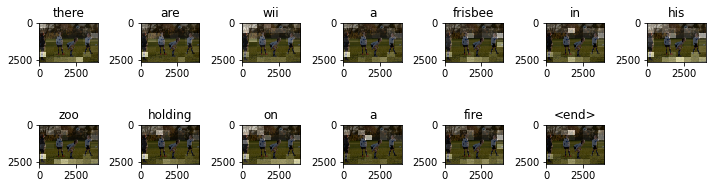

In [ ]:
#@title Chèn một link ảnh có sẵn vào đây
link = "https://static.scientificamerican.com/sciam/cache/file/9097719F-9951-42CC-AC84E68BFCB50358_source.jpg" #@param {type:"string"}

image_url = link if link else 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_name = image_url.split('/')[-1][:-4]
image_path = tf.keras.utils.get_file(image_name + image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

#### Sử dụng file được tải từ máy tính

In [ ]:
#@title Tải ảnh lên và tiến hành dự đoán
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  image = plt.imread(fn)
  plt.imshow(image)

  result, attention_plot = evaluate(fn)
  print('Prediction Caption:', ' '.join(result))
  plot_attention(fn, result, attention_plot)
  # opening the image
  Image.open(image_path)

In [ ]:
# Testing link: https://static.scientificamerican.com/sciam/cache/file/9097719F-9951-42CC-AC84E68BFCB50358_source.jpg